## Create price curve and plot it

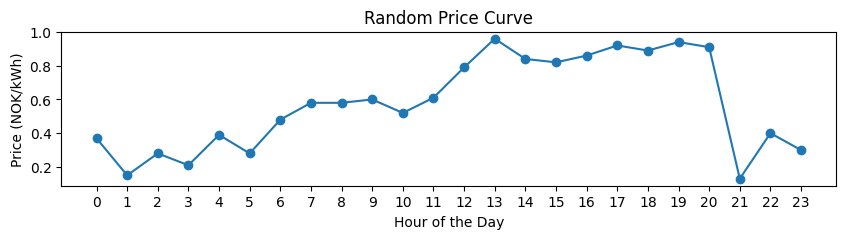

In [9]:
import random
import matplotlib.pyplot as plt
import numpy as np

random.seed(5410)

def generate_price_curve(peak_hours, morning_hours):
    price_curve = {}
    for hour in range(24):
        if hour in peak_hours:
            price_curve[hour] = round(random.uniform(0.8, 1.0), 2)  # Peak price range: 0.2 to 1.0 NOK/kWh
        elif hour in morning_hours:
            price_curve[hour] = round(random.uniform(0.4, 0.8), 2)
        else:
            price_curve[hour] = round(random.uniform(0.1, 0.5), 2)  # Default to off-peak price for non-defined hours
    return price_curve

# Define peak and off-peak hours (for example)
peak_hours = {13, 14, 15, 16, 17, 18, 19, 20}  # 5:00 pm to 8:00 pm
morning_hours = {7, 8, 9, 10, 11, 12}

# Generate a random price curve
price_curve = generate_price_curve(peak_hours, morning_hours)

# Plot the generated price curve
plt.figure(figsize=(10, 2))
plt.plot(price_curve.keys(), price_curve.values(), marker='o', linestyle='-')
plt.title("Random Price Curve")
plt.xlabel("Hour of the Day")
plt.ylabel("Price (NOK/kWh)")
plt.grid(False)
plt.xticks(range(24))
plt.show()


## Problem 2

In [10]:
import pyomo.environ as pe

l_h = 2/10 #hourly consumption of lighting kWh
h_h = 9.6/24 #hourly consumption of heating kWh
r_h = 3.96/24 #hourly consumption of refrigerator kWh
s_h = 3.9/2 #hourly consumption of stove kWh
tv_h = 0.6/5 #hourly consumption of refrigerator kWh
pc_h = 0.6/2 #hourly consumption of pc kWh

In [11]:
#Energy consumption for non-shiftable appliances per appliance, per hour kWh
x_ns = np.asarray([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, l_h, l_h, l_h, l_h, l_h, l_h, l_h, l_h, l_h, l_h, 0, 0, 0, 0],
        [h_h,h_h,h_h,h_h,h_h,h_h,h_h,h_h,h_h,h_h,h_h,h_h,h_h,h_h,h_h,h_h,h_h,h_h,h_h,h_h,h_h,h_h,h_h,h_h],
        [r_h,r_h,r_h,r_h,r_h,r_h,r_h,r_h,r_h,r_h,r_h,r_h,r_h,r_h,r_h,r_h,r_h,r_h,r_h,r_h,r_h,r_h,r_h,r_h],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,s_h,s_h,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,tv_h,tv_h,tv_h,tv_h,tv_h,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,pc_h,pc_h,0,0,0,0,0]])

E         = [1.44, 1.94, 2.5, 9.9] #daily energy consumption of the 4 shiftable appliances, kWh
power_lim = [1.8, 1, 3 ,3.6] #power rate of these appliances. I have just searched them online when not available at reference 2. The EV one is taken from the lesson slides, for a nissan leaf. in kWh

m = pe.ConcreteModel()

m.nt    = pe.Param(initialize = len(price_curve), domain=pe.Integers) #number of time slots
m.T     = pe.Set(initialize = range(m.nt())) #set of timeslots
m.price = pe.Param(m.T, initialize = price_curve) #associates a price with each timeslot
m.I     = pe.RangeSet(0,len(E)-1) #set of indices for the shiftable appliances

#domain=non-negative integers because energy consumption cannot be negative
m.x_s   = pe.Var(m.I, m.T, domain=pe.NonNegativeReals) #hourly energy consumption of shiftable appliance i at hour t

# Define objective function
def obj_rule(model):
    total_cost = 0
    # Add cost of non-shiftable appliances
    for t in model.T:
        total_cost += model.price[t] * (sum(model.x_s[i, t] for i in model.I) + sum(x_ns[i, t] for i in range(len(x_ns))))
    return total_cost

m.obj = pe.Objective(rule=obj_rule, sense=pe.minimize)

m.cons = pe.ConstraintList() #create a list of constraints
for i in m.I:
  #add constraints to the list created above
  m.cons.add(expr = sum(m.x_s[i,t] for t in m.T)==E[i]) #constraint for total daily energy use
  for t in m.T:
    m.cons.add(expr = m.x_s[i,t] <= power_lim[i])
  
results = pe.SolverFactory('cbc').solve(m)

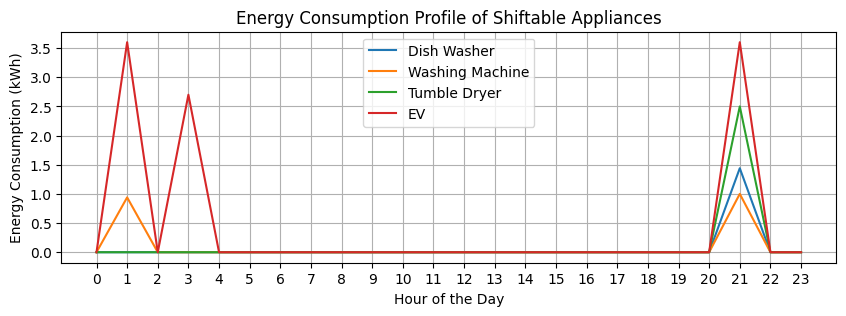

In [12]:
# Extract the solution values
solution_values = {(i, t): pe.value(m.x_s[i, t]) for i in m.I for t in m.T}

app_names = ['Dish Washer', 'Washing Machine', 'Tumble Dryer','EV']

# Plot the energy consumption profile
plt.figure(figsize=(10, 3))
for i in range(len(E)):
    plt.plot(range(len(m.T)), [solution_values[i, t] for t in m.T], label=f"{app_names[i]}")
plt.title("Energy Consumption Profile of Shiftable Appliances")
plt.xlabel("Hour of the Day")
plt.ylabel("Energy Consumption (kWh)")
plt.xticks(range(len(m.T)))
plt.legend()
plt.grid(True)
plt.show()

# Problem 3

In [27]:
from pyomo.environ import ConcreteModel, Param, Var, Objective, minimize, ConstraintList, NonNegativeReals, RangeSet, Set, SolverFactory

#assuming the price curve generated in Task 2 is applicable here as well

#constants
NUM_HOUSEHOLDS = 30
EV_OWNERSHIP = 10  #fraction of households own an EV
NUM_APPLIANCES = len(app_names)  #number of shiftable appliances from Problem 2

model = ConcreteModel()

#parameters
model.nt = Param(initialize=len(price_curve))  # Number of time slots
model.T = RangeSet(0, model.nt - 1)  # Set of time slots
model.price = Param(model.T, initialize=price_curve)  # Price curve
model.households = RangeSet(0, NUM_HOUSEHOLDS - 1)  # Set of households
model.appliances = RangeSet(0, NUM_APPLIANCES - 1)  # Set of appliances

#variable to model energy consumption of appliance i in household j at time t
model.x_s = Var(model.appliances, model.households, model.T, domain=NonNegativeReals)

#objective: Minimize total energy cost for all households
def total_cost_rule(model):
    return sum(model.price[t] * sum(model.x_s[i, j, t] for i in model.appliances for j in model.households) for t in model.T)

model.total_cost = Objective(rule=total_cost_rule, sense=minimize)

#constraints
model.constraints = ConstraintList()

for j in model.households:
    for i in model.appliances:
        if app_names[i] == 'EV' and j < NUM_HOUSEHOLDS - EV_OWNERSHIP:
            #for households without an EV, set the daily energy requirement for the EV to 0
            model.constraints.add(sum(model.x_s[i, j, t] for t in model.T) == 0)
        else:
            #for all other appliances or households with an EV, enforce the standard daily energy requirement
            model.constraints.add(sum(model.x_s[i, j, t] for t in model.T) == E[i])
        for t in m.T:
            model.constraints.add(expr = model.x_s[i,j,t] <= power_lim[i])

#solve the model
solver = SolverFactory('cbc')
results = solver.solve(model)



#### Adding results to a csv

In [38]:
import pandas as pd

solution_values = {(app, house, t): pe.value(model.x_s[app, house, t]) for app in model.appliances for house in model.households for t in model.T}


# Transform the dictionary into a DataFrame for easier manipulation and exporting
df = pd.DataFrame(list(solution_values.items()), columns=['Key', 'Energy Consumption'])
df[['Appliance', 'Household', 'Time Slot']] = pd.DataFrame(df['Key'].tolist(), index=df.index)
df.drop(columns=['Key'], inplace=True)

# Reorder the DataFrame columns
df = df[['Appliance', 'Household', 'Time Slot', 'Energy Consumption']]

#remove rows where Energy Consumption is 0 to reduce sparsity
df_non_zero = df[df['Energy Consumption'] > 0]

#pivot the table to have one row per (Household, Appliance) pair and columns for each time slot
pivoted_df = df_non_zero.pivot_table(index=['Household', 'Appliance'], 
                                     columns='Time Slot', 
                                     values='Energy Consumption', 
                                     fill_value=0)

#reset the index to turn the MultiIndex back into columns (optional)
pivoted_df.reset_index(inplace=True)

#flatten the columns to remove the multi-level structure introduced by pivot_table
pivoted_df.columns = [str(col) if not isinstance(col, tuple) else f'Time Slot {col[1]}' for col in pivoted_df.columns.values]

#export to CSV
pivoted_df.to_csv('./out/pivoted_energy_consumption.csv', index=False)